# Inter-subreddit analysis of positive and negative voted comments

### John Burt

[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/springboard/blob/master/capstone_1/reddit_intersub_analysis_data_story.ipynb) 


### Introduction:

The social media site Reddit is divided into many different communities called subreddits (subs). Each sub covers a specific topic or theme and tends to have regular users posting comments. 

The goal of my first Capstone project is to develop a toxic comment classifier. One of the questions I need to answer is the degree to which the language used in a toxic comment is unique to the sub it is posted in. If toxic comments are mostly the same in every sub, then I can train a single classifier and apply it to every subreddit. If, however the comments in each sub use substantially different language, then I will likely need to train a unique classifier for each subreddit.

In this notebook, I explored the differences and similarities in the comment language used among several subs. I also examined whether the language used in positively rated comments was different from negatively rated comments, and whether political subs use more similar language than non-political subs.


In [1]:
from IPython.display import HTML
# from IPython.display import Image
# Image("eyeexam.jpg")

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

### Methods

The comment data used in this analysis was [acquired using PRAW](https://github.com/johnmburt/springboard/blob/master/capstone_1/reddit_collect_comments_v1.ipynb) from 12 subs. 8 of the subs were labelled non-political, and 4 were labelled political in nature. Each comment was scored [in another script](https://github.com/johnmburt/springboard/blob/master/capstone_1/reddit_PCA_score_analysis.ipynb) for community approval or disapproval based on the vote score, then standardized and ranged between -5 and +5.

In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np
import datetime
import time
import csv
import glob


# source data folder 
srcdir = './data_labeled/'

# the subreddits I'll be analyzing
sub2use = ['aww', 'funny', 'todayilearned','askreddit',
           'photography', 'gaming', 'videos', 'science',
           'politics', 'politicaldiscussion',             
           'conservative', 'the_Donald']

# flag subs as political or not
political = [False,False,False,False,False,False,False,False,
            True,True,True,True]

# load all labelled CSVs
dfs = []
for subname in sub2use:
    pathname = srcdir+'comment_sample_'+subname+'_labeled.csv'
#     print('reading',pathname)
    tdf = pd.read_csv(pathname)
    dfs.append(tdf)

# combine all subreddit datasets into one  
df = pd.concat(dfs).drop_duplicates()

# remove any deleted or removed comments 
df = df[(df.text!='[deleted]') & (df.text!='[removed]')]

# drop samples with NaNs
df.dropna(inplace=True)

# print('\nTotal comment samples read:',df.shape[0])


From the larger set of comments, I selected only comments that were above or below a specified score threshold: comments with scores above 2 were deemed "positive", while ones with scores below -2 were "negative". Then I subsampled equal numbers of positive and negative comments from each sub.

In [3]:
"""Select the most positive and negative scored comments

Split dataset into positive and negative scored comments. Positively scored comments are "liked" by other users, while negatively scored comments are "disliked".

Scores for all subreddits are ranged between -5 and +5
"""

# threshold for selecting positive and nagative scored comments
score_thresh = 2

df_pos = df[df.pca_score > score_thresh]
df_neg = df[df.pca_score < -score_thresh]

# print('df_pos.shape',df_pos.shape,'df_neg.shape',df_neg.shape)

In [4]:
"""Subsample comments

Balance samples so that there are equal numbers for all subreddits
"""

def subsample_comments(df, samplesize=None, minchars=0, verbose=False):
    """Randomly subsample text in a df so that all categories 
      (in column 'sub_name') have equal numbers of samples
    """
    subnames = df.sub_name.unique()
    dfs = []
    print()
    for subname in subnames:
        tdf = df[(df['sub_name']==subname) & 
                 (df['text'].str.len()>=minchars)]
        if tdf.shape[0] < samplesize:
            print('warning: only %5d samples in category %s'%(
                tdf.shape[0],subname))
        elif verbose:
            print('%5d samples in category %s'%(
                tdf.shape[0],subname))
        dfs.append( tdf.sample(min(tdf.shape[0],samplesize)) )
    return pd.concat(dfs)
  

numsamples = 1000 # number of samples to take from each subreddit
minchars = 10 # threshold for rejecting too-short comments

dfss_pos = subsample_comments(df_pos, samplesize=numsamples, 
                             minchars=minchars, verbose=False)
dfss_neg = subsample_comments(df_neg, samplesize=numsamples, 
                             minchars=minchars, verbose=False)

# print('after subsampling: dfss_pos.shape',dfss_pos.shape,
#       'dfss_neg.shape',dfss_neg.shape)

### Word similarity of comments between subs

How similar are comments made between the different subs? Are there different trends in similarity among positive vs. negative comments? Is the language used in political subs more similar than with other non-political subs?

For this analysis, I minimally pre-processed the comment text, count-vectorized, and used the cosine similarity measure on the vectors to assess relative similarity.

In [5]:
"""Prepare the text for analysis and vectorization

Clean up the text by 
- Removing non-alphanumeric characters
- Remove stop words
- Making lowercase
- Stemming
"""

import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords as sw

def process_comment_text(comments, stemmer=None, 
                         regexstr=None, lowercase=True,
                         removestop=False):
    """Process a list of comment text by optionally:
              stemming, 
              applying a regex expression,
              converting to lowercase,
              removing stop words
    """
    
    if type(stemmer) == str:
        if stemmer.lower() == 'porter':
            stemmer = PorterStemmer()
        elif stemmer.lower() == 'snowball':
            stemmer = SnowballStemmer(language='english')
        else:
            stemmer = None
            
    processed = comments
    
    # make text lowercase
    if lowercase == True:
#         print('make text lowercase')
        processed = processed.str.lower()
        
    # remove stop words
    # NOTE: stop words w/ capitals not removed!
    if removestop == True:
#         print('remove stop words')
        stopwords = sw.words("english")
        processed = processed.map(lambda text: ' '.join([word for word in text.split() if word not in stopwords]))
        
    # apply regex expression
    if regexstr is not None:
#         print('apply regex expression')
        regex = re.compile(regexstr) 
        processed = processed.str.replace(regex,' ')
        
    # stemming
    # NOTE: stemming makes all lowercase
    if stemmer is not None:
#         print('stemming')
        processed = processed.map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
        
#     print('done')
        
    return processed

# set up text pre-processing arguments
#  NOTE: normally I'd stem in an NLP task but here I want 
#        whole words for the wordcloud figures below.
processkwargs = {
    'stemmer': None,
    'regexstr':"[^a-zA-Z0-9'\s]", # drop non-alphanumeric, spaces or '
    'lowercase':True,
    'removestop':False
                }

# clean up the selected high and low scored comment text,
dfss_pos['text_cl'] = process_comment_text(dfss_pos['text'], **processkwargs)
dfss_neg['text_cl'] = process_comment_text(dfss_neg['text'], **processkwargs)


In [6]:
"""Combine all text within each subreddit"""

def combine_text_by_category(df,catcol,textcol,catlist):
    """Combine text in a df col into one string, 
      separate by a given category col. 
    """
    cats = df[catcol].unique()
    textlist = []
    for cat in catlist:
        textlist.append(df[df[catcol]==cat][textcol].str.cat(sep=' '))
    return textlist
    
text_concat_pos = (
    combine_text_by_category(dfss_pos,'sub_name', 'text_cl', sub2use) )
                        
text_concat_neg = (
    combine_text_by_category(dfss_neg,'sub_name', 'text_cl', sub2use) )

# print resulting text sizes by subreddit
if False:
    print('positive comment total char count:')
    for i,subname in enumerate(sub2use):
        print(subname,len(text_concat_pos[i]))

    print('\nnegative comment total char count:')
    for i,subname in enumerate(sub2use):
        print(subname,len(text_concat_neg[i]))
    

In [7]:
"""Vectorize the text"""

from sklearn.feature_extraction.text import TfidfVectorizer

# define model defaults for TF-IDF vectorizer.
tfidfargs = {
    "analyzer":'word', 
    "max_features" : None,
    "max_df" : 0.75, # Filters out terms that occur in >= n% docs
    "min_df" : 5, # Filters out terms that occur in <= n documents.
    "ngram_range":(1, 1), # unigrams
    "stop_words" : None,   #None, #"english", # Strips out “stop words”
    "use_idf" : False
    }

# create the vectorizer 
vectorizer = TfidfVectorizer(**tfidfargs)

# Transform the comment text into vectorized data.
X_pos = vectorizer.fit_transform(text_concat_pos)
X_neg = vectorizer.fit_transform(text_concat_neg)

# print('X_pos.shape',X_pos.shape, 'X_neg.shape',X_neg.shape)

In [8]:
"""Calculate cosine similarity

Apply cosine similarity to the word vectors created by TfidfVectorizer.

The result will be a square confusion matrix.
"""

from sklearn.metrics.pairwise import cosine_similarity

# calculate pairwise similarities
cossim_pos = cosine_similarity(X_pos)
cossim_neg = cosine_similarity(X_neg)

# convert to pandas dataframes
df_mx_pos_2 = pd.DataFrame(cossim_pos,
                             index=sub2use, 
                             columns=sub2use)
df_mx_neg_2 = pd.DataFrame(cossim_neg,
                             index=sub2use, 
                             columns=sub2use)

A plot of the similarity matrices shows some interesting patterns. First, the positive and negative comments were fairly similar in terms of which subs were more or less similar. Political subs (the lower-rightmost 4 in the matrix) were more similar to each other, while non-political subs were generally less similar to any others.

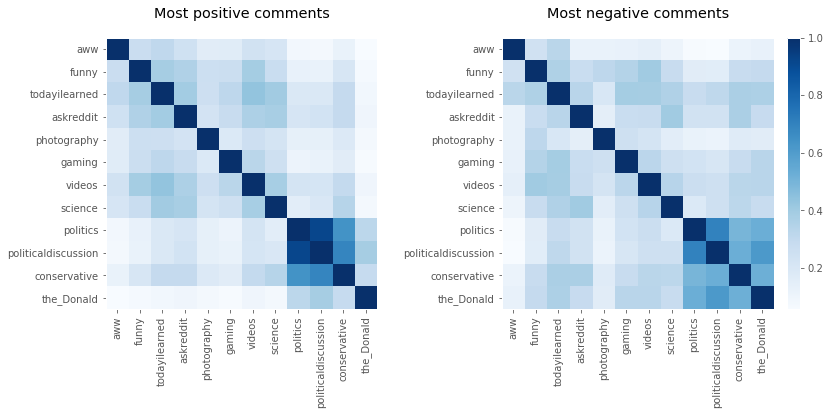

In [9]:
"""Plot similarity matrices

How similar are the word vectors between subreddits for positive 
and negatively scored comments?

I've ordered the subreddits by whether they are non-political 
(the first 8 categories) or political (the last 4 categories). 
If there are differences between political vs non-political, 
then you should see a pattern of darker (more correlated) blocks 
on the diagonal surrounded by lighter blocks. And, that's exactly 
what you see here.
"""

def plot_similarity_mx_df(similarity_mx, title='', plot_colorbar=True):
    """Display a similarity matrix as a square colored table 
    with color darkness indicating degree of similarity between
    each comparison pair.
    """
    ax = plt.gca()
    cax = ax.matshow(similarity_mx, cmap=plt.cm.Blues)
    if plot_colorbar:
        plt.gcf().colorbar(cax,fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(similarity_mx.columns)))
    ax.set_yticks(range(len(similarity_mx.columns)))
    ax.set_xticklabels(similarity_mx.columns, rotation = 90)
    ax.set_yticklabels(similarity_mx.columns)
    ax.xaxis.set_ticks_position('bottom')
    ax.grid(False)
    plt.title(title)
    
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plot_similarity_mx_df(df_mx_pos_2, 
                      title='Most positive comments',
                      plot_colorbar=False)   
    
plt.subplot(1,2,2)
plot_similarity_mx_df(df_mx_neg_2, 
                      title='Most negative comments',
                      plot_colorbar=True)   
 

Multi-Dimensional Scaling can map a cosine similarity matrice onto a 2D space, where more similar comparison pairs are closer on the map. 

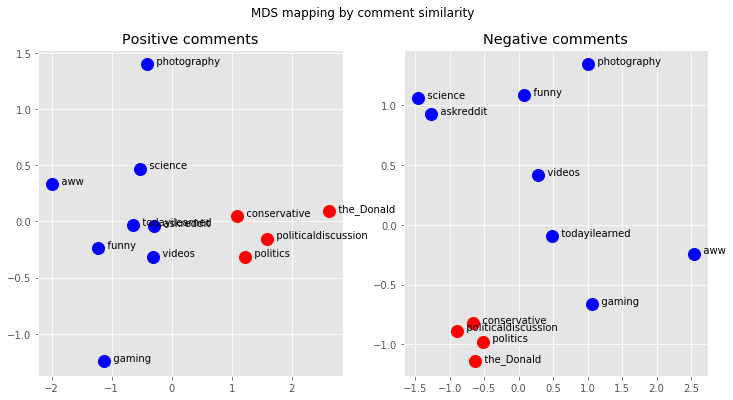

In [10]:
"""Map sub comment text similarities using Multi-Dimensional Scaling

Next, I take the reciprocal of the cosine similarity matrices to 
create a dis-similarity (or distance) matrix, then use 
Multi-Dimensional Scaling to map how close each subreddit is to 
the others.

Note that the MDS algorithm will randomly rotate and/or invert 
the mapping space each time it is run. That means you have to 
look at the relationship between points in the map, not their 
absolute locations.
"""

from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_MDS_mapping(similarity_mx, labels, ndims=2, title='', 
                     politics_flag=None):
    """Given a similarity matrix, calculate the MDS coordinates
            and then plot them on a map. 
       Plot political subs in red, non-political in blue.
       """
    
    mds = MDS(n_components=ndims, n_init=100, metric=False, 
              max_iter=1000,eps=.00001,dissimilarity='precomputed' )
    coords = mds.fit_transform(1-similarity_mx)
    coords = StandardScaler().fit_transform(coords)
    coords = PCA(n_components=ndims).fit_transform(coords)

    labels = ['   '+s for s in labels]

    plt.title(title)

    plt.plot(coords[politics_flag,0], coords[politics_flag,1],'ro', markersize=12)
    for x, y, subname in zip(coords[politics_flag,0], coords[politics_flag,1], 
                             np.array(labels)[politics_flag]):    
        plt.text(x, y, subname)

    plt.plot(coords[~np.array(politics_flag),0], coords[~np.array(politics_flag),1],
             'bo', markersize=12)
    for x, y, subname in zip(coords[~np.array(politics_flag),0], coords[~np.array(politics_flag),1], 
                             np.array(labels)[~np.array(politics_flag)]):    
        plt.text(x, y, subname)

        
# plot positive and negative comment data in separate figures        
fig = plt.figure(figsize=(12,6))

plt.suptitle('MDS mapping by comment similarity')

plt.subplot(1,2,1)
plot_MDS_mapping(df_mx_pos_2, sub2use, ndims=2, 
                 title='Positive comments', 
                 politics_flag=political)

plt.subplot(1,2,2)
plot_MDS_mapping(df_mx_neg_2, sub2use, ndims=2, 
                 title='Negative comments', 
                 politics_flag=political)


MDS mapping the subreddit comment similarities reveals several interesting trends:

- The political subs are clustered closely together, meaning the comments used similar language.


- The non-political subs are much more spread out and show little or no clustering, suggesting that they each have a more unique vocabulary.


- Positively and negatively scored comments show very similar mappings (bearing in mind that MDS fits will rotate and flip mappings at random). 


### Political vs non-political wordclouds

I want to look at the actual words most common in each of my categories of text: positive vs negative, political vs non-political. Do some words predict a positive or negative comment score, or political vs non-political? For this analysis, I'll use the wordcloud visualization tool to show the most common words in each category of comment: positive vs. negative,  political vs. non-political.

In [11]:
"""Combine all text for each category

To prepare the text for the wordcloud analysis, 
I need to combine all text for each of the categories
"""

# concat high rated political comments 
wordstr_politics_pos = ' '.join(text_concat_pos[8:])
# concat low rated political comments 
wordstr_politics_neg = ' '.join(text_concat_neg[8:])

# concat high rated non-political comments 
wordstr_nonpolitics_pos = ' '.join(text_concat_pos[:8])
# concat low rated non-political comments 
wordstr_nonpolitics_neg = ' '.join(text_concat_neg[:8])


In [12]:
"""Remove words that are common to all categories

Wordclouds are susceptible to common and uninteresting words 
(such as stop words) showing up as most frequent (i.e. bigger 
font size) and obscuring the interesting words. Here, I remove 
the common words to all datasets so the unique words to each 
category can pop out.
"""

from collections import Counter, OrderedDict

def text_to_wordlist(text):
    """Create wordlist from text str, strip whitespace"""
    return [s.strip() for s in text.replace('\n',' ').split(' ')]
    
def list_words_by_most_common(wordlist):
    """Given list of words from a text, returns list of all words, 
        sorted by most repeated with duplicated removed
    """
    # sort by most common, drop duplicates, return list
    return list(OrderedDict.fromkeys(
        sorted(wordlist, key=Counter(wordlist).get, reverse=True)))

wordcount = 500 # number of most common words to remove 

# convert text strings into lists of words
wordlist_politics_pos = text_to_wordlist(wordstr_politics_pos)
wordlist_politics_neg = text_to_wordlist(wordstr_politics_neg)
wordlist_nonpolitics_pos = text_to_wordlist(wordstr_nonpolitics_pos)
wordlist_nonpolitics_neg = text_to_wordlist(wordstr_nonpolitics_neg)

# get a list of words common to all categories
common_to_all = ( 
    set(list_words_by_most_common(wordlist_politics_pos)[:wordcount]) &
    set(list_words_by_most_common(wordlist_politics_neg)[:wordcount]) &
    set(list_words_by_most_common(wordlist_nonpolitics_pos)[:wordcount]) &
    set(list_words_by_most_common(wordlist_nonpolitics_neg)[:wordcount]) 
    )

# reform text after dropping words common to all categories
wordstr_politics_pos2 = ' '.join([w for w in wordlist_politics_pos if w not in common_to_all])
wordstr_politics_neg2 = ' '.join([w for w in wordlist_politics_neg if w not in common_to_all])
wordstr_nonpolitics_pos2 = ' '.join([w for w in wordlist_nonpolitics_pos if w not in common_to_all])
wordstr_nonpolitics_neg2 = ' '.join([w for w in wordlist_nonpolitics_neg if w not in common_to_all])


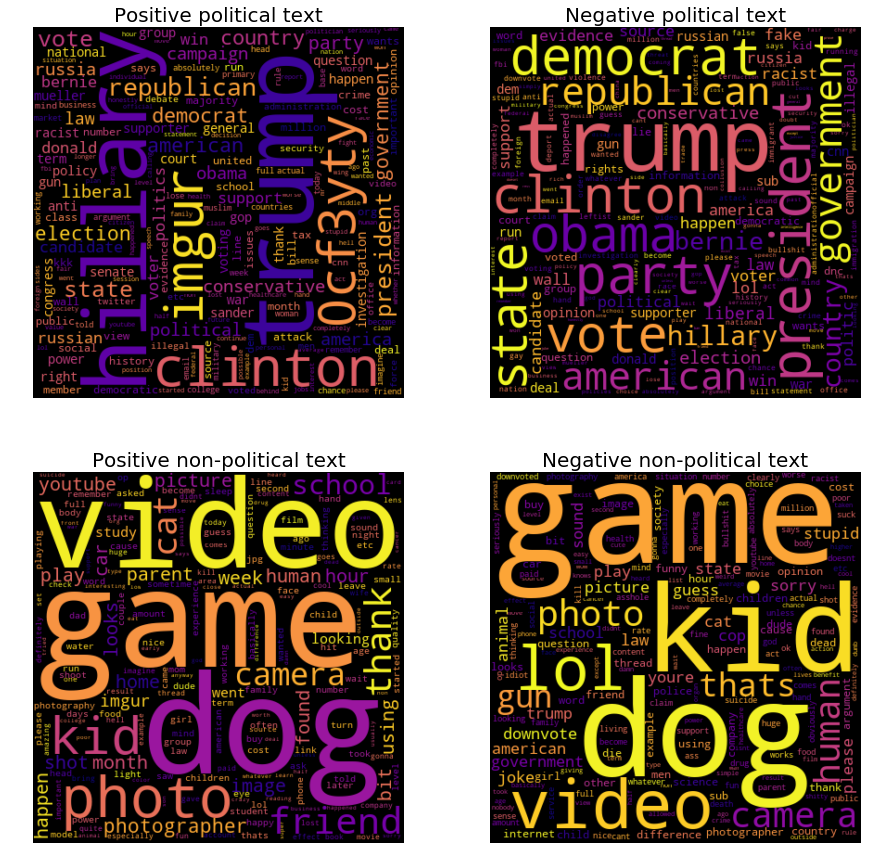

In [13]:
"""Word clouds of each category of comment"""

from wordcloud import WordCloud

def plot_wordcloud(text, title):
    """Plot word cloud of given text"""
    # Generate a word cloud image
    wordcloud = (WordCloud(width=400, height=400,
                           colormap='plasma',collocations=False)
                 .generate(text))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis("off");
    
# plot 2 x 2 grid of word clouds of each category of comment
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plot_wordcloud(wordstr_politics_pos2,'Positive political text')

plt.subplot(2,2,2)
plot_wordcloud(wordstr_politics_neg2,'Negative political text')

plt.subplot(2,2,3)
plot_wordcloud(wordstr_nonpolitics_pos2,'Positive non-political text')

plt.subplot(2,2,4)
plot_wordcloud(wordstr_nonpolitics_neg2,'Negative non-political text')


Looking at these wordclouds, several trends emerge:

- For political subs, the words used in positive and negative comments are very similar, with "Trump" being the most commonly used word. However, there are differences. For example, the odd term "0cf3yty" shows up frequently only in the positive comments. A little research revealed that this is part of a URL for an unflattering image of Hillary Clinton that conservatives were "freeping" - frequently posting and then upvoting to manipulate Reddit ranking of the image.


- For non-political subs, generally the same words were dominant (game, dog, video, kid). This is likely due to the frequent use of these words in comments regardless of their vote scores.

## Word clouds for words common to positive vs negative comments

I'm interested in viewing word differences between positive and negative comments across all subs. Are there certain words that are used in positive or negative comments?

For this analysis, I combine all positive comments and all negative comments and look at the wordclouds for each. Are there words that predict positive or negative voting scores? 

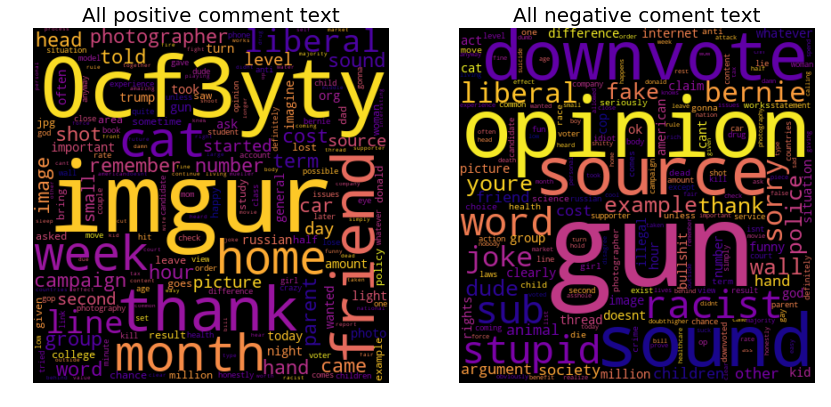

In [14]:
# number of common words to remove
wordcount = 500

# create lists of positive and negative comment words
wordlist_pos = text_to_wordlist(wordstr_politics_pos + wordstr_nonpolitics_pos)
wordlist_neg = text_to_wordlist(wordstr_politics_neg + wordstr_nonpolitics_neg)

# get list of words common to positive and negative comments
common_to_all = ( 
    set(list_words_by_most_common(wordlist_pos)[:wordcount]) &
    set(list_words_by_most_common(wordlist_neg)[:wordcount]) 
    )

# re-assemble text for all positive and negative comments, 
#  subtracting common words
wordstr_pos = ' '.join([w for w in wordlist_pos if w not in common_to_all])
wordstr_neg = ' '.join([w for w in wordlist_neg if w not in common_to_all])

# plot word clouds of positive and negative comment texts
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plot_wordcloud(wordstr_pos,'All positive comment text')

plt.subplot(1,2,2)
plot_wordcloud(wordstr_neg,'All negative coment text')


It appears that there are words that make sense showing up in in positive comments (friend, thank, home, 0cf3yty), while some words in negative comments are appropriately "negative" as well (racist, downvote, stupid, fake). 

Image URL component "imgur" shows up frequently in the positive comments for both political and non-political subs. It may be that users tend to upvote image links more frequently regardless of the topic.

### Conclusions

My main question for this analysis was whether individual subs have unique vocabularies, and this analysis has shown that to be true. Furthermore, subs with similar topics (e.g., political subs) have similar vocabs in their comments compared to others. This indicates that I should use different classifier models for each sub, using only comments from within each sub for training. 

